Analysis of Simulation Studies
----------
Author: Albert Ulmer  
Date: 2022-06-04 - 2022-06-30

In [1]:
# autoreload packages
%load_ext autoreload
%autoreload 2

# import data & plotting libraries
import numpy as np
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
plt.style.use('default')

from matplotlib import cm
import sqlite3

# import own libraries
import util
import plot
import config




In [2]:
### Set global flag whether to save plots to files or not
writefiles = 1

if writefiles:
    print("Writing output files!")
else:
    print("Leaving files alone!")


Writing output files!


In [3]:
### Set global flag whether to print debug messages while running code
showdebug = 1

if showdebug:
    print("Showing debug messages!")
else:
    print("No debug messages will be shown!")

Showing debug messages!


# Load Simulation Data


In [20]:
# connect to SQLite database
try:
    conn = sqlite3.connect('./database_gurobi/dsmdata-sim.sqlite3')
    conn_cbc = sqlite3.connect('./database_cbc/dsmdata-sim.sqlite3')
    conn_cbc_3200u = sqlite3.connect('./database_cbc_3200u/dsmdata-sim.sqlite3')

    print('Connected to database...')
except:
    print('Database error!')
    exit()

Connected to database...


In [21]:
# execute SQL query
queryps = open("sqls/model_griddraw_comptime_v2.sql").read()
dfps = pd.read_sql_query(queryps, conn)
if showdebug: print(dfps.head())


                   config   model  pvprc  bessprc  period   GridDraw  \
0  direct_pv0.00_bess0.00  direct    0.0      0.0       0  35.000000   
1  direct_pv0.00_bess0.00  direct    0.0      0.0       1  35.000000   
2  direct_pv0.00_bess0.00  direct    0.0      0.0       2  35.000000   
3  direct_pv0.00_bess0.00  direct    0.0      0.0       3  35.000000   
4  direct_pv0.00_bess0.00  direct    0.0      0.0       4  22.566137   

   runningtime  SSR  SCR  
0        0.092  0.0  0.0  
1        0.085  0.0  0.0  
2        0.090  0.0  0.0  
3        0.075  0.0  0.0  
4        0.069  0.0  0.0  


In [22]:
# execute SQL query
queryps = open("sqls/model_griddraw_comptime_v1.sql").read()
dfps_cbc = pd.read_sql_query(queryps, conn_cbc)
if showdebug: print(dfps_cbc.head())

                   config   model  pvprc  bessprc  period   GridDraw  \
0  direct_pv0.00_bess0.00  direct    0.0      0.0       0  35.000000   
1  direct_pv0.00_bess0.00  direct    0.0      0.0       1  35.000000   
2  direct_pv0.00_bess0.00  direct    0.0      0.0       2  35.000000   
3  direct_pv0.00_bess0.00  direct    0.0      0.0       3  35.000000   
4  direct_pv0.00_bess0.00  direct    0.0      0.0       4  16.629566   

   runningtime  
0        0.391  
1        0.509  
2        0.425  
3        0.848  
4        0.396  


In [23]:
# execute SQL query
queryps = open("sqls/model_griddraw_comptime_v1.sql").read()
dfps_cbc_3200u = pd.read_sql_query(queryps, conn_cbc_3200u)
if showdebug: print(dfps_cbc_3200u.head())

                   config   model  pvprc  bessprc  period   GridDraw  \
0  direct_pv0.00_bess0.00  direct    0.0      0.0       0  35.000000   
1  direct_pv0.00_bess0.00  direct    0.0      0.0       1  35.000000   
2  direct_pv0.00_bess0.00  direct    0.0      0.0       2  35.000000   
3  direct_pv0.00_bess0.00  direct    0.0      0.0       3  35.000000   
4  direct_pv0.00_bess0.00  direct    0.0      0.0       4  16.629566   

   runningtime  
0        0.597  
1        0.418  
2        0.426  
3        0.632  
4        0.395  


# Analysis

## Peakshaving

### PAPR & Standard Deviation

In [7]:
dfps_pivot = dfps.pivot_table(values="GridDraw", index=["pvprc", "bessprc"], columns="model", aggfunc=["mean", "std", "max", util.papr])
if showdebug: print(dfps_pivot.head())

                    mean                                                 std  \
model             direct   perfect      pred       rule     stoch     direct   
pvprc bessprc                                                                  
0.0   0.00      9.985679  7.239803  6.935674   9.557517  6.380580  13.187867   
      0.25      9.926774  7.185215  6.984688   9.928856  6.824040  13.400652   
      0.50     10.195326  7.503482  6.708817  10.143384  6.075857  13.753115   
      0.75     10.426733  7.647507  6.768521  10.313446  6.140306  13.867475   
      1.00     10.628929  6.959095  6.690311  10.479839  6.611492  13.806045   

                                                          max             \
model           perfect      pred       rule     stoch direct    perfect   
pvprc bessprc                                                              
0.0   0.00     2.863509  2.184120  12.816586  2.337204   35.0  12.420000   
      0.25     2.424694  2.442684  13.190774  1.733167 

In [8]:
# Translation dictionaries for plotting
model_desc = {}
model_desc["direct"] = "Direct Charging"
model_desc["rule"] = "Rule-based Charging"
model_desc["pred"] = "Predictive Charging"
model_desc["stoch"] = "Stochastic Charging"
model_desc["perfect"] = "Perfect Information"

model_abbr = {}
model_abbr["direct"] = "Direct"
model_abbr["rule"] = "Rule-based"
model_abbr["pred"] = "Predictive"
model_abbr["stoch"] = "Stochastic"
model_abbr["perfect"] = "Perfect"

metric_desc = {}
metric_desc["max"] = "Maximum Grid Draw [kW]"
metric_desc["mean"] = "Average Grid Draw [kW]"
metric_desc["papr"] = "Peak-to-Average Power Ratio"
metric_desc["std"] = "Standard Deviation"

variable_desc = {}
variable_desc["pvprc"] = "PV size [%]"
variable_desc["bessprc"] = "BESS size [%]"

In [9]:
models = ['direct', 'rule', 'pred', 'stoch', 'perfect']
metrics = ['max', 'mean', 'std', 'papr']


In [10]:
for model in models: #list(model_desc.keys()):
    for metric in metrics: #list(metric_desc.keys()):
        if showdebug: print("Working on model", model, "and metric", metric)
        label = model + "_" + metric
        my_data = np.array(dfps_pivot.loc[:,(metric)].reset_index()[["pvprc", "bessprc", model]])
        if my_data[:,2].std() == 0:
            myplot = plot.contour_plot(mydata = my_data, order = 0, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel = metric_desc[metric]) #, title = model_desc[model])
        else:
            myplot = plot.contour_plot(mydata = my_data, order = 2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel = metric_desc[metric]) #, title = model_desc[model])
        if writefiles:
            myplot.savefig("output/peakshaving_contour_"+label+".png",
                           bbox_inches='tight', dpi=300)
            plt.close(myplot)
        #if model in  ["direct", "rule"] and metric == "max":
        if my_data[:,2].std() == 0:
            mysurf = plot.surface_plot(mydata = my_data, order = 0, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel = metric_desc[metric]) #, title = model_desc[model])
        else:
            mysurf = plot.surface_plot(mydata = my_data, order = 2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel = metric_desc[metric]) #, title = model_desc[model])
        if writefiles:
            mysurf.savefig("output/peakshaving_surface_"+label+".png",
                           bbox_inches='tight', dpi=300)
            plt.close(mysurf)

Working on model direct and metric max
Working on model direct and metric mean
Working on model direct and metric std
Working on model direct and metric papr
Working on model rule and metric max
Working on model rule and metric mean
Working on model rule and metric std
Working on model rule and metric papr
Working on model pred and metric max
Working on model pred and metric mean
Working on model pred and metric std
Working on model pred and metric papr
Working on model stoch and metric max
Working on model stoch and metric mean
Working on model stoch and metric std
Working on model stoch and metric papr
Working on model perfect and metric max
Working on model perfect and metric mean
Working on model perfect and metric std
Working on model perfect and metric papr


In [11]:
dfps_pivot.round(2)


mean                               std                       \
model         direct perfect  pred   rule stoch direct perfect  pred   rule   
pvprc bessprc                                                                 
0.00  0.00      9.99    7.24  6.94   9.56  6.38  13.19    2.86  2.18  12.82   
      0.25      9.93    7.19  6.98   9.93  6.82  13.40    2.42  2.44  13.19   
      0.50     10.20    7.50  6.71  10.14  6.08  13.75    2.34  2.14  13.33   
      0.75     10.43    7.65  6.77  10.31  6.14  13.87    2.12  1.60  13.59   
      1.00     10.63    6.96  6.69  10.48  6.61  13.81    2.58  2.02  13.62   
0.25  0.00      9.36    4.82  5.30   9.01  4.91  13.08    3.11  3.08  12.71   
      0.25      9.01    5.14  4.89   9.22  4.91  12.83    2.51  2.64  13.06   
      0.50      8.89    5.29  5.63   9.19  4.23  13.12    2.72  1.70  12.79   
      0.75      9.31    5.22  5.44   9.27  4.91  13.02    2.63  2.33  13.06   
      1.00      9.59    5.24  4.82   9.36  4.65  13.81    2.38  2.39  13.16   
0.50  0.00      8.94    3.49  3.81   8.57  3.86  12.81    2.77  3.32  12.47   
      0.25      8.30    3.33  3.49   8.50  3.62  12.50    3.18  3.04  12.59   
      0.50      8.22    3.40  3.70   8.89  3.55  12.74    3.01  3.03  12.59   
      0.75      8.70    2.99  3.66   8.56  3.15  13.06    3.16  2.60  12.55   
      1.00      7.86    3.27  4.15   8.13  3.16  13.01    2.82  2.63  12.40   
0.75  0.00      8.27    1.85  3.06   8.35  3.09  12.61    2.35  3.28  12.43   
      0.25      8.41    1.65  2.70   8.14  2.68  12.93    2.01  3.06  12.77   
      0.50      7.60    1.94  2.33   8.45  2.68  12.87    2.64  2.81  12.44   
      0.75      7.93    2.01  2.17   8.32  2.19  12.92    2.77  2.49  12.52   
      1.00      7.66    2.03  1.92   7.72  2.68  12.80    2.31  2.22  12.30   
1.00  0.00      7.49    0.74  1.83   7.63  2.37  12.61    1.53  2.35  12.51   
      0.25      7.14    0.61  1.71   8.25  1.88  12.91    1.34  2.19  12.68   
      0.50      7.30    1.00  1.74   7.87  1.55  12.67    1.76  1.99  12.49   
      0.75      7.50    0.96  1.49   7.35  1.43  12.73    1.49  1.95  12.37   
      1.00      7.43    1.01  1.41   7.77  1.05  12.67    1.68  1.88  12.38   

                       max                               papr                \
model         stoch direct perfect   pred  rule  stoch direct perfect  pred   
pvprc bessprc                                                                 
0.00  0.00     2.34   35.0   12.42  12.42  35.0  12.35   3.51    1.72  1.79   
      0.25     1.73   35.0   13.42  12.42  35.0   9.89   3.53    1.87  1.78   
      0.50     2.43   35.0   12.42   9.28  35.0  10.41   3.43    1.66  1.38   
      0.75     2.47   35.0   12.42   9.28  35.0  10.21   3.36    1.62  1.37   
      1.00     2.03   35.0    9.84  12.42  35.0  11.62   3.29    1.41  1.86   
0.25  0.00     2.81   35.0    8.98   8.28  35.0   8.68   3.74    1.86  1.56   
      0.25     2.54   35.0    8.28   8.28  35.0   9.83   3.88    1.61  1.69   
      0.50     2.92   35.0    9.61   8.28  35.0   9.70   3.94    1.82  1.47   
      0.75     2.60   35.0    8.28   9.41  35.0   9.03   3.76    1.58  1.73   
      1.00     2.66   35.0    8.28  10.15  35.0   8.67   3.65    1.58  2.11   
0.50  0.00     2.40   35.0    8.28   8.28  35.0   8.28   3.91    2.37  2.17   
      0.25     2.74   35.0    9.02   9.21  35.0   8.28   4.22    2.71  2.64   
      0.50     2.68   35.0    8.28   8.40  35.0   9.07   4.26    2.43  2.27   
      0.75     2.55   35.0    8.28   8.62  35.0   8.28   4.02    2.77  2.35   
      1.00     2.60   35.0    8.28   8.28  35.0   8.28   4.45    2.53  1.99   
0.75  0.00     2.49   35.0    6.65   8.28  35.0   7.67   4.23    3.58  2.71   
      0.25     2.21   35.0    4.89   8.83  35.0   6.23   4.16    2.96  3.28   
      0.50     2.33   35.0    7.64   8.28  35.0   8.28   4.61    3.93  3.55   
      0.75     2.43   35.0    8.28   8.28  35.0   6.22   4.42    4.13  3.82   
      1.00     2.28   35.0    7.92   5.46  35.0   8.12   4.57    

In [12]:
dfps_pivot_pretty = dfps_pivot.round(2).copy()
dfps_pivot_pretty.index.names = ["PV %", "BESS %"]
dfps_pivot_pretty.columns.set_levels(["Average", "Std. Dev.", "Maximum", "PAPR"], level=0, inplace=True)
dfps_pivot_pretty.columns.set_levels(["Direct", "Perfect", "Predictive", "Rule-based", "Stochastic"], level=1, inplace=True)
#dfps_pivot_pretty.to_latex(buf="output/peakshaving_results.tex", bold_rows=True)
if writefiles:
    dfps_pivot_pretty.loc[:, ["Maximum", "Average"]].to_latex(
        buf="output/peakshaving_results1.tex", bold_rows=True)
    dfps_pivot_pretty.loc[:, ["Std. Dev.", "PAPR"]].to_latex(
        buf="output/peakshaving_results2.tex", bold_rows=True)


C:\Users\aulmer\AppData\Local\Temp\ipykernel_22108\2686266419.py:3: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfps_pivot_pretty.columns.set_levels(["Average", "Std. Dev.", "Maximum", "PAPR"], level=0, inplace=True)
C:\Users\aulmer\AppData\Local\Temp\ipykernel_22108\2686266419.py:4: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfps_pivot_pretty.columns.set_levels(["Direct", "Perfect", "Predictive", "Rule-based", "Stochastic"], level=1, inplace=True)
C:\Users\aulmer\AppData\Local\Temp\ipykernel_22108\2686266419.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfps_pivot_pretty.loc[:, ["Maximum", "Average"]].to_latex(
C:\Users\aulmer\AppData\Local\Temp\ipyke

In [13]:
list(model_abbr.keys())


['direct', 'rule', 'pred', 'stoch', 'perfect']

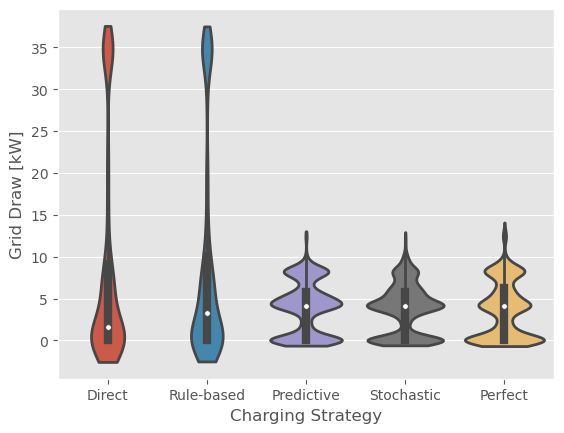

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

f, ax = plt.subplots()
sns.violinplot(data=dfps, x="model", y="GridDraw", order=list(model_abbr.keys()),
               alpha=1, bw=.2, cut=1, linewidth=2)
ax.set_xlabel("Charging Strategy")
ax.set_ylabel("Grid Draw [kW]")
ax.set_xticklabels(list(model_abbr.values()))

if writefiles:
    plt.savefig("output/GridDraw_violin.png",
                bbox_inches='tight', dpi=300)
    #plt.close()

## Computation Time

### Gurobi

In [15]:
dfrt_pivot = dfps.pivot_table(values="runningtime",  index="model", aggfunc=["mean", "std", "max"])
if showdebug: print(dfrt_pivot.head())

               mean         std         max
        runningtime runningtime runningtime
model                                      
direct     0.093707    0.031066       0.225
perfect    0.096285    0.035100       0.407
pred       0.083878    0.016502       0.210
rule       0.112247    0.025997       0.255
stoch      1.775482    1.912423      39.710


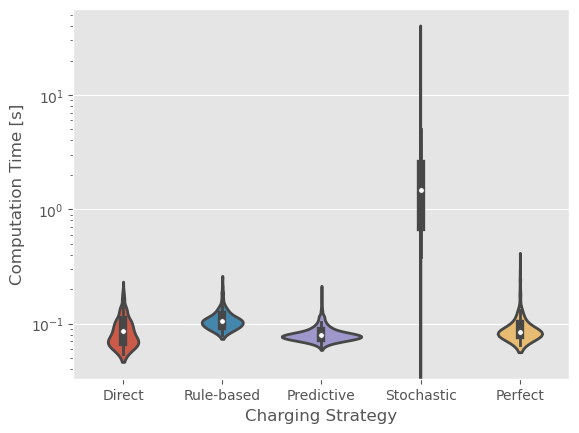

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# models = ["Direct", "Rule-based", "Predictive", "Stochastic", "Perfect"]

f, ax = plt.subplots()
sns.violinplot(data=dfps, x="model", y="runningtime", order=list(model_abbr.keys()),
               alpha=1, bw=.25, cut=1, linewidth=2)
ax.set_xlabel("Charging Strategy")
ax.set_ylabel("Computation Time [s]")
ax.set_xticklabels(list(model_abbr.values()))
ax.set_yscale("log")

if writefiles:
    plt.savefig("output/runningtime_violin.png",
                bbox_inches='tight', dpi=300)
    #plt.close()


### CBC


In [17]:
dfrt_pivot_cbc = dfps_cbc.pivot_table(values="runningtime",  index="model", aggfunc=["mean", "std", "max"])
if showdebug: print(dfrt_pivot_cbc.head())

               mean         std         max
        runningtime runningtime runningtime
model                                      
direct     0.802870    0.560041       3.425
perfect    1.159845    0.455330       3.051
pred       0.987227    0.417810       3.623
rule       1.077557    8.004902     192.697
stoch    319.004558  219.651427    1803.512


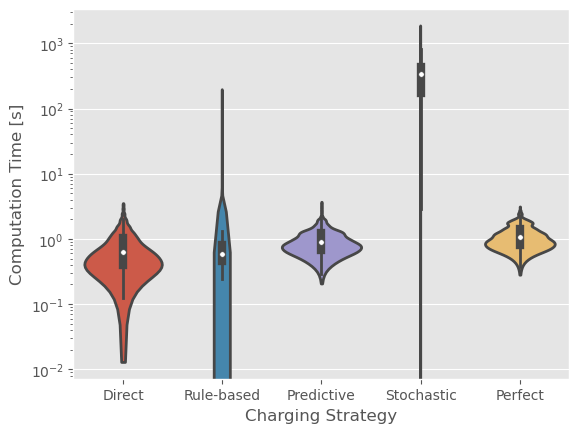

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

f, ax = plt.subplots()
sns.violinplot(data=dfps_cbc, x="model", y="runningtime", order=list(model_abbr.keys()),
               alpha=1, bw=.2, cut=1, linewidth=2)
ax.set_xlabel("Charging Strategy")
ax.set_ylabel("Computation Time [s]")
ax.set_xticklabels(list(model_abbr.values()))
ax.set_yscale("log")

if writefiles:
    plt.savefig("output/runningtime_violin_cbc.png",
                bbox_inches='tight', dpi=300)
    #plt.close()


### CBC on Ryzen 3 3200U

In [24]:
dfrt_pivot_cbc_3200u = dfps_cbc_3200u.pivot_table(values="runningtime",  index="model", aggfunc=["mean", "std", "max"])
if showdebug: print(dfrt_pivot_cbc_3200u.head())

               mean         std         max
        runningtime runningtime runningtime
model                                      
direct     0.782250    0.716321       2.982
perfect    1.235042    0.737463       3.864
pred       1.210938    0.984270       5.982
rule       1.404219    6.465288      63.909
stoch    229.477646  281.612335    1568.841


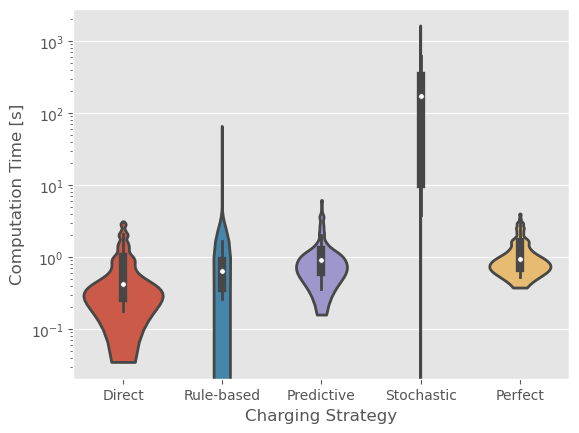

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

f, ax = plt.subplots()
sns.violinplot(data=dfps_cbc_3200u, x="model", y="runningtime", order=list(model_abbr.keys()),
               alpha=1, bw=.2, cut=1, linewidth=2)
ax.set_xlabel("Charging Strategy")
ax.set_ylabel("Computation Time [s]")
ax.set_xticklabels(list(model_abbr.values()))
ax.set_yscale("log")

if writefiles:
    plt.savefig("output/runningtime_violin_cbc_3200u.png",
                bbox_inches='tight', dpi=300)
    #plt.close()


In [31]:
dfrt_pivot.merge(dfrt_pivot_cbc, left_index=True, right_index=True, suffixes=["_i7-Gurobi", "_i7-CBC"]).round(3)

,mean_i7-Gurobi,std_i7-Gurobi,max_i7-Gurobi,mean_i7-CBC,std_i7-CBC,max_i7-CBC
,runningtime,runningtime,runningtime,runningtime,runningtime,runningtime
model,,,,,,
direct,0.094,0.031,0.225,0.803,0.560,3.425
perfect,0.096,0.035,0.407,1.160,0.455,3.051
pred,0.084,0.017,0.210,0.987,0.418,3.623
rule,0.112,0.026,0.255,1.078,8.005,192.697
stoch,1.775,1.912,39.710,319.005,219.651,1803.512


In [37]:
dfps["env"] = "Gurobi on i7"
dfps_cbc["env"] = "CBC on i7"
dfps_cbc_3200u["env"] = "CBC on 3200U"

dfrt_all = pd.concat([dfps, dfps_cbc, dfps_cbc_3200u])
dfrt_all

dfrt_pivot_all = dfrt_all.pivot_table(values="runningtime",  index="model", columns=["env"], aggfunc=["mean", "std", "max"])
if showdebug: print(dfrt_pivot_all.head())

                mean                                   std              \
env     CBC on 3200U   CBC on i7 Gurobi on i7 CBC on 3200U   CBC on i7   
model                                                                    
direct      0.782250    0.802870     0.093707     0.716321    0.560041   
perfect     1.235042    1.159845     0.096285     0.737463    0.455330   
pred        1.210938    0.987227     0.083878     0.984270    0.417810   
rule        1.404219    1.077557     0.112247     6.465288    8.004902   
stoch     229.477646  319.004558     1.775482   281.612335  219.651427   

                              max                         
env     Gurobi on i7 CBC on 3200U CBC on i7 Gurobi on i7  
model                                                     
direct      0.031066        2.982     3.425        0.225  
perfect     0.035100        3.864     3.051        0.407  
pred        0.016502        5.982     3.623        0.210  
rule        0.025997       63.909   192.697        0.

In [38]:
if writefiles:
    dfrt_pivot_all.to_latex(buf="output/comptime_results.tex", bold_rows=True)

C:\Users\aulmer\AppData\Local\Temp\ipykernel_22108\1840639952.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfrt_pivot_all.to_latex(buf="output/comptime_results.tex", bold_rows=True)


## Charging Comfort


In [19]:
# execute SQL query
querycc = open("sqls/model_charging_comfort_v2.sql").read()
dfcc = pd.read_sql_query(querycc, conn)
if showdebug:
    print(dfcc.head())


                   config   model  pvprc  bessprc      EVSOC
0  direct_pv0.00_bess0.00  direct    0.0     0.00  36.369045
1  direct_pv0.00_bess0.25  direct    0.0     0.25  36.214366
2  direct_pv0.00_bess0.50  direct    0.0     0.50  36.038748
3  direct_pv0.00_bess0.75  direct    0.0     0.75  36.072837
4  direct_pv0.00_bess1.00  direct    0.0     1.00  36.072837


In [20]:
c0 = config.varpvbess_1()
c0["E_EV_MAX"]
dfcc['SOCperc']=round(dfcc.EVSOC/c0["E_EV_MAX"],2)
dfcc[dfcc.model == "stoch"]

,config,model,pvprc,bessprc,EVSOC,SOCperc
100,stoch_pv0.00_bess0.00,stoch,0.00,0.00,27.629617,0.73
101,stoch_pv0.00_bess0.25,stoch,0.00,0.25,28.053938,0.74
102,stoch_pv0.00_bess0.50,stoch,0.00,0.50,26.696589,0.70
103,stoch_pv0.00_bess0.75,stoch,0.00,0.75,26.608736,0.70
104,stoch_pv0.00_bess1.00,stoch,0.00,1.00,27.455459,0.72
105,stoch_pv0.25_bess0.00,stoch,0.25,0.00,29.372331,0.77
106,stoch_pv0.25_bess0.25,stoch,0.25,0.25,29.044550,0.76
107,stoch_pv0.25_bess0.50,stoch,0.25,0.50,28.464319,0.75
108,stoch_pv0.25_bess0.75,stoch,0.25,0.75,28.260149,0.74
109,stoch_pv0.25_bess1.00,stoch,0.25,1.00,29.896463,0.79


In [21]:
models

['direct', 'rule', 'pred', 'stoch', 'perfect']

In [22]:
for model in models:  # list(model_desc.keys()):
    if showdebug:
        print("Working on model", model)
    label = model
    my_data = np.array(dfcc[dfcc.model == model].reset_index()[
                        ["pvprc", "bessprc", "SOCperc"]])
    #myplot = plot.contour_plot(mydata=my_data, order=2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel="Satisfaction [%]", title=model_desc[model], color='green')
    myplot = plot.contour_plot(mydata=my_data, order=2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel="Satisfaction [%]", color='green')
    if writefiles:
        myplot.savefig("output/chargingcomfort_contour_"+label+".png",
                        bbox_inches='tight', dpi=300)
        plt.close(myplot)
    #mysurf = plot.surface_plot(mydata=my_data, order=2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel="Satisfaction [%]", title=model_desc[model], color='green')
    mysurf = plot.surface_plot(mydata=my_data, order=2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel="Satisfaction [%]", color='green')
    if writefiles:
        mysurf.savefig("output/chargingcomfort_surface_"+label+".png",
                        bbox_inches='tight', dpi=300)
        plt.close(mysurf)


Working on model direct
Working on model rule
Working on model pred
Working on model stoch
Working on model perfect


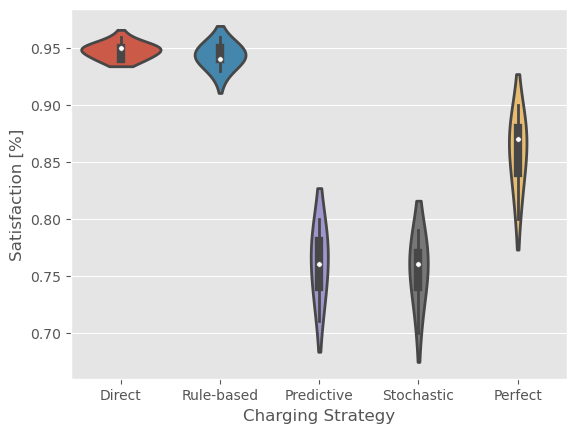

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

f, ax = plt.subplots()
sns.violinplot(data=dfcc, x="model", y="SOCperc", order=list(model_abbr.keys()),
               alpha=1, bw=1, cut=1, linewidth=2)
ax.set_xlabel("Charging Strategy")
ax.set_ylabel("Satisfaction [%]")
ax.set_xticklabels(list(model_abbr.values()))

if writefiles:
    plt.savefig("output/chargingcomfort_violin.png",
                bbox_inches='tight', dpi=300)
    #plt.close()


### SSR & SCR

In [24]:
dfps.loc[(dfps.pvprc > 0) & (dfps.period == 0)]

,config,model,pvprc,bessprc,period,GridDraw,runningtime,SSR,SCR
120,direct_pv0.25_bess0.00,direct,0.25,0.00,0,35.000000,0.201,0.08,0.51
144,direct_pv0.25_bess0.25,direct,0.25,0.25,0,35.000000,0.126,0.15,0.90
168,direct_pv0.25_bess0.50,direct,0.25,0.50,0,35.000000,0.195,0.15,0.91
192,direct_pv0.25_bess0.75,direct,0.25,0.75,0,35.000000,0.142,0.14,0.86
216,direct_pv0.25_bess1.00,direct,0.25,1.00,0,35.000000,0.182,0.14,0.85
...,...,...,...,...,...,...,...,...,...
2880,stoch_pv1.00_bess0.00,stoch,1.00,0.00,0,5.544549,0.632,0.58,0.99
2904,stoch_pv1.00_bess0.25,stoch,1.00,0.25,0,4.590602,0.939,0.58,0.99
2928,stoch_pv1.00_bess0.50,stoch,1.00,0.50,0,4.484244,0.567,0.57,0.99
2952,stoch_pv1.00_bess0.75,stoch,1.00,0.75,0,4.953917,0.682,0.57,0.98


In [25]:
pvmetrics = ["SSR", "SCR"]

pvmetric_desc = {}
pvmetric_desc["SSR"] = "Self-sufficiency Rate [%]"
pvmetric_desc["SCR"] = "Self-consumption Rate [%]"


In [26]:
np.array(dfps.loc[dfps["model"] == "stoch"].reset_index()[["pvprc", "bessprc", "SSR"]])

array([[0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       ...,
       [1.  , 1.  , 0.81],
       [1.  , 1.  , 0.94],
       [1.  , 1.  , 0.92]])

Working on model direct and metric SSR
Working on model direct and metric SCR
Working on model rule and metric SSR
Working on model rule and metric SCR
Working on model pred and metric SSR
Working on model pred and metric SCR
Working on model stoch and metric SSR
Working on model stoch and metric SCR
Working on model perfect and metric SSR
Working on model perfect and metric SCR


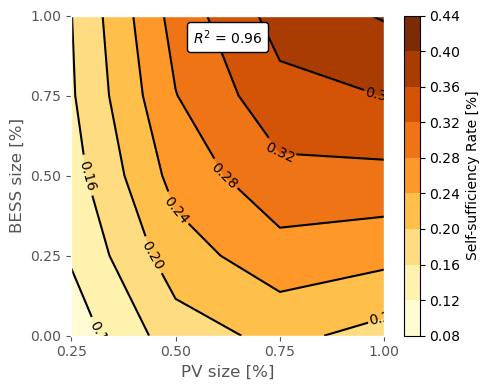

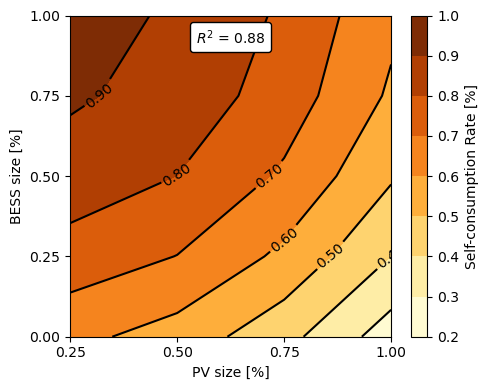

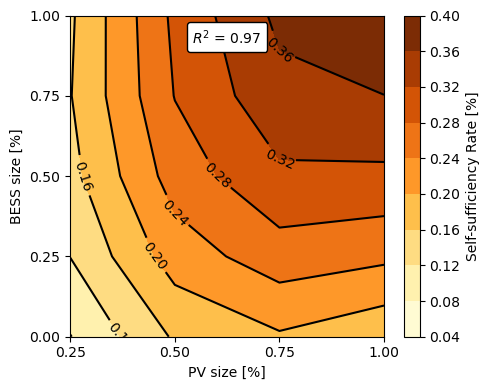

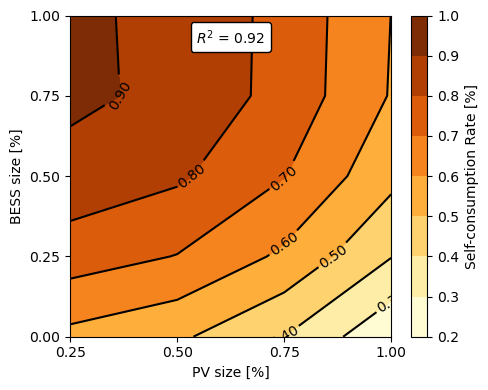

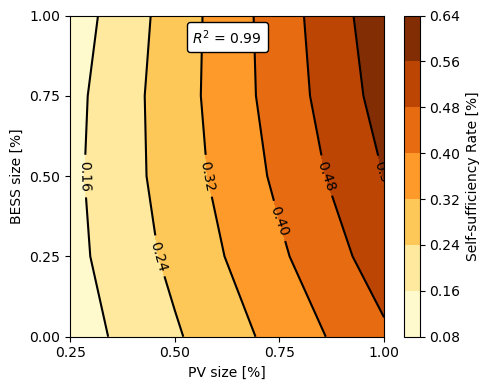

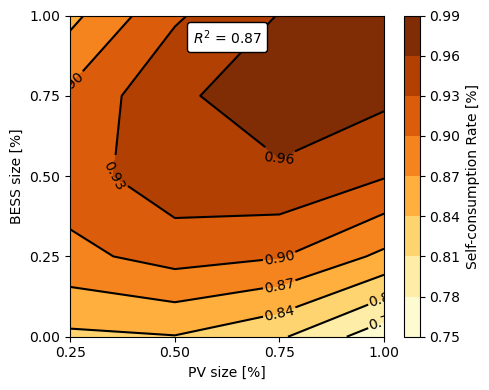

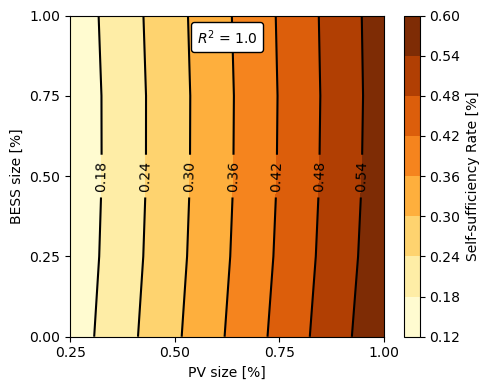

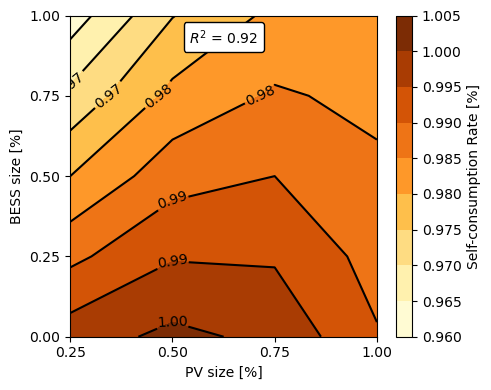

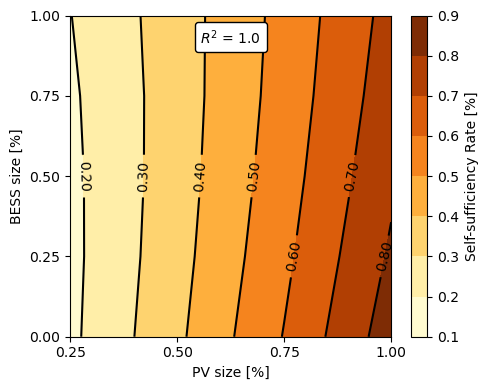

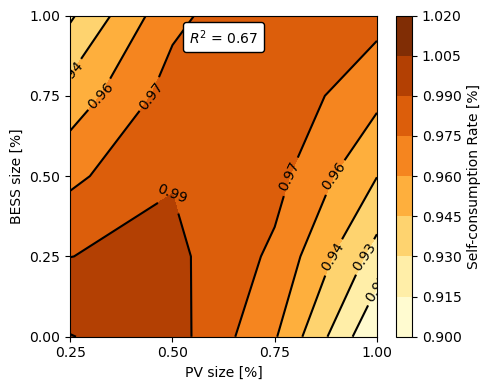

In [27]:
for model in models:  # list(model_desc.keys()):
    for metric in pvmetrics:  # list(metric_desc.keys()):
        if showdebug:
            print("Working on model", model, "and metric", metric)
        label = model + "_" + metric
        my_data = np.array(dfps.loc[(dfps["model"] == model) & (dfps.period == 0) & (dfps.pvprc > 0)].reset_index()[["pvprc", "bessprc", metric]])

        if my_data[:, 2].std() == 0:
            #myplot = plot.contour_plot(mydata=my_data, order=0, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], title=model_desc[model], color="yellow")
            myplot = plot.contour_plot(mydata=my_data, order=0, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], color="yellow")
        else:
            #myplot = plot.contour_plot(mydata=my_data, order=2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], title=model_desc[model], color="yellow")
            myplot = plot.contour_plot(mydata=my_data, order=2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], color="yellow")
        if writefiles:
            myplot.savefig("output/pvmetric_contour_"+label+".png",
                           bbox_inches='tight', dpi=300)
            plt.close(mysurf)
        if my_data[:, 2].std() == 0:
            #mysurf = plot.surface_plot(mydata=my_data, order=0, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], title=model_desc[model], color="yellow")
            mysurf = plot.surface_plot(mydata=my_data, order=0, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], color="yellow")
        else:
            #mysurf = plot.surface_plot(mydata=my_data, order=2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], title=model_desc[model], color="yellow")
            mysurf = plot.surface_plot(mydata=my_data, order=2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], color="yellow")
        if writefiles:
            mysurf.savefig("output/pvmetric_surface_"+label+".png",
                           bbox_inches='tight', dpi=300)
            plt.close(mysurf)


### Summary

In [28]:
# label the configurations
dfps["config"] = "other"
dfps.loc[(dfps.pvprc == 0) & (dfps.bessprc == 0), "config"] = "LVG only"
dfps.loc[(dfps.pvprc == 1) & (dfps.bessprc == 0), "config"] = "LVG + PV"
dfps.loc[(dfps.pvprc == 0) & (dfps.bessprc == 1), "config"] = "LVG + BESS"
dfps.loc[(dfps.pvprc == 1) & (dfps.bessprc == 1), "config"] = "LVG + PV + BESS"
for model in dfps.model.unique():
    dfps.loc[(dfps.model == model), "model"] = model_abbr[model]
dfps

,config,model,pvprc,bessprc,period,GridDraw,runningtime,SSR,SCR
0,LVG only,Direct,0.0,0.0,0,35.000000,0.092,0.00,0.00
1,LVG only,Direct,0.0,0.0,1,35.000000,0.085,0.00,0.00
2,LVG only,Direct,0.0,0.0,2,35.000000,0.090,0.00,0.00
3,LVG only,Direct,0.0,0.0,3,35.000000,0.075,0.00,0.00
4,LVG only,Direct,0.0,0.0,4,22.566137,0.069,0.00,0.00
...,...,...,...,...,...,...,...,...,...
2995,LVG + PV + BESS,Stochastic,1.0,1.0,19,0.000000,0.593,0.95,0.76
2996,LVG + PV + BESS,Stochastic,1.0,1.0,20,0.000000,0.862,0.98,0.75
2997,LVG + PV + BESS,Stochastic,1.0,1.0,21,0.000000,2.060,0.81,0.68
2998,LVG + PV + BESS,Stochastic,1.0,1.0,22,0.000000,1.096,0.94,0.76


In [29]:
dfps_pivot2 = dfps[dfps.config != "other"].pivot_table(values="GridDraw", columns=["config"], index=["model"], aggfunc=["max", "mean", "std", util.papr])
if showdebug: print(dfps_pivot2.head())

                  max                                             mean  \
config     LVG + BESS   LVG + PV LVG + PV + BESS   LVG only LVG + BESS   
model                                                                    
Direct      35.000000  35.000000           35.00  35.000000  10.628929   
Perfect      9.837942   4.140000            4.14  12.420000   6.959095   
Predictive  12.420000   8.139675            4.14  12.420000   6.690311   
Rule-based  35.000000  35.000000           35.00  35.000000  10.479839   
Stochastic  11.624194   7.333725            5.14  12.351338   6.611492   

                                                      std             \
config      LVG + PV LVG + PV + BESS  LVG only LVG + BESS   LVG + PV   
model                                                                  
Direct      7.494389        7.428391  9.985679  13.806045  12.605466   
Perfect     0.739176        1.010902  7.239803   2.581088   1.528504   
Predictive  1.826925        1.413237  6.935674 

In [30]:
#models = ['direct', 'rule', 'pred', 'stoch', 'perfect']
models2 = list(model_abbr.values())
models2.reverse()
metrics2 = list(model_abbr.keys()) #['max', 'mean', 'std', 'papr']
configs = ["LVG only", "LVG + PV", "LVG + BESS", "LVG + PV + BESS"]



In [31]:
dfps_pivot2["max"].loc[models2,configs]

config,LVG only,LVG + PV,LVG + BESS,LVG + PV + BESS
model,,,,
Perfect,12.420000,4.140000,9.837942,4.14
Stochastic,12.351338,7.333725,11.624194,5.14
Predictive,12.420000,8.139675,12.420000,4.14
Rule-based,35.000000,35.000000,35.000000,35.00
Direct,35.000000,35.000000,35.000000,35.00


In [32]:
# from mpl_toolkits.mplot3d import Axes3D
for metric in metrics:  # list(metric_desc.keys()):
    if showdebug:
        print("Working on metric", metric)
    label = metric
    plt.style.use("default")
    mybar3d = plot.bar3d_plot(dfps_pivot2[metric].loc[models2, configs], xlabel="Configuration", ylabel="Model", zlabel=metric_desc[metric], color="rainbow")
    if writefiles:
        mybar3d.savefig("output/model_summary_bar3d_"+label+".png",
                        bbox_inches='tight', dpi=300)
        plt.close(mybar3d)



Working on metric max
Working on metric mean
Working on metric std
Working on metric papr


In [33]:
dfps_pivot2["max"].loc[models2[0:3],configs].mean(axis=1)


model
Perfect       7.634486
Stochastic    9.112314
Predictive    9.279919
dtype: float64

In [110]:
dfps_pivot3 = dfps_pivot2["max"].loc[models2[0:3],configs].round(2).median(axis=1).round(2)
#dfps_pivot3["Average"] = dfps_pivot3.median(axis=1).round(2)
dfps_pivot3 = pd.DataFrame(dfps_pivot3)
dfps_pivot3.columns = ["Average"]
dfps_pivot3

,Average
model,
Perfect,6.99
Stochastic,9.48
Predictive,10.28


In [111]:
models3 = list(model_abbr.values())[2:]
models3


['Predictive', 'Stochastic', 'Perfect']

In [112]:
dfps_pivot4 = pd.DataFrame(dfps_pivot3.loc[models3, "Average"]).T
dfps_pivot4["VSS"] = -1 * (dfps_pivot4["Stochastic"] - dfps_pivot4["Predictive"])
dfps_pivot4["EVPI"] = -1 * (dfps_pivot4["Perfect"] - dfps_pivot4["Stochastic"])
dfps_pivot4.index = ["Grid Draw Maximum [kW]"]
dfps_pivot4


model,Predictive,Stochastic,Perfect,VSS,EVPI
Grid Draw Maximum [kW],10.28,9.48,6.99,0.8,2.49


In [113]:
if writefiles:
    dfps_pivot4.to_latex(
        buf="output/model_summary_vss_evpi.tex", bold_rows=True)


C:\Users\aulmer\AppData\Local\Temp\ipykernel_26972\420681063.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfps_pivot4.to_latex(
